In [4]:
# tools
import numpy as np
import pandas as pd
# plot
import seaborn as sns
from matplotlib import pyplot as plt
# functions
from math import floor
from pathlib import Path
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter, CoxPHFitter

## Cargar datos

In [5]:
clicks = Path('../data/raw/clicks.csv.gzip')
clicks = pd.read_csv(clicks, compression='gzip')

In [6]:
clicks.columns

Index(['advertiser_id', 'action_id', 'source_id', 'created', 'country_code',
       'latitude', 'longitude', 'wifi_connection', 'carrier_id', 'trans_id',
       'os_minor', 'agent_device', 'os_major', 'specs_brand', 'brand',
       'timeToClick', 'touchX', 'touchY', 'ref_type', 'ref_hash'],
      dtype='object')

## Distribucion

In [7]:
timeToEvent = (clicks.query("timeToClick <= 30")
                     .dropna(subset=['timeToClick'])
                     .timeToClick.map(floor))

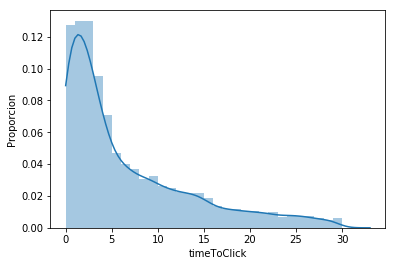

In [13]:
ax = sns.distplot(timeToEvent, kde_kws={'clip': (0.0, 60.0)}, bins=30)
ax.set_ylabel('Proporcion')
plt.savefig('../assets/clicks_timeToClick-distribution.png', bbox_inches='tight')

## Analisis de supervivencia

In [14]:
def assign_event(t):
    return 1 if t <= (60) else 0

In [15]:
survival = (clicks.loc[:, ['timeToClick', 'brand']]
                  .fillna({'timeToClick': 999})
                  .assign(timeToClick = lambda df: df.timeToClick.map(floor),
                          E = lambda df: df.timeToClick.map(assign_event))
                  .rename(columns={'timeToClick': 'T'})
                  .query("T < 60"))

In [16]:
T1, E1 = survival.loc[lambda df: df.brand==2]['T'], survival.loc[lambda df: df.brand==2]['E']
T2, E2 = survival.loc[lambda df: df.brand==0]['T'], survival.loc[lambda df: df.brand==0]['E']
# T3, E3 = survival.loc[lambda df: df.brand==1]['T'], survival.loc[lambda df: df.brand==1]['E']

In [17]:
kmf = KaplanMeierFitter()

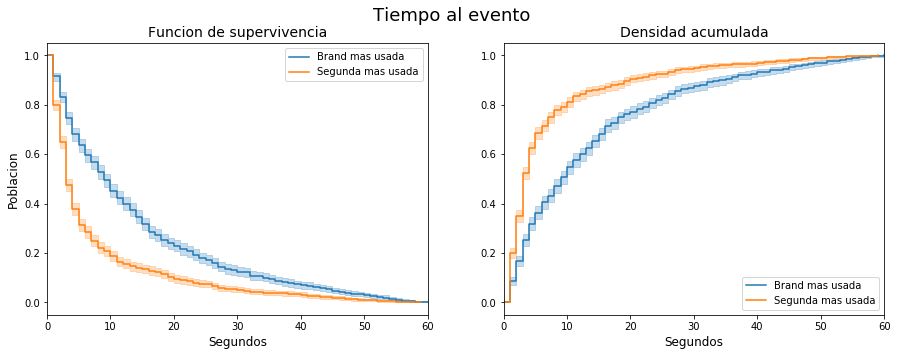

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
kmf.fit(T1 + 1, event_observed=E1, label='Brand mas usada')
kmf.plot_survival_function(ax=ax1)
kmf.plot_cumulative_density(ax=ax2)
kmf.fit(T2 + 1, event_observed=E2, label='Segunda mas usada')
kmf.plot_survival_function(ax=ax1)
kmf.plot_cumulative_density(ax=ax2)
fig.suptitle('Tiempo al evento', size=18)
ax1.set_title('Funcion de supervivencia', size=14)
ax1.set_xlabel('Segundos', size=12)
ax1.set_ylabel('Poblacion', size=12)
ax2.set_title('Densidad acumulada', size=14)
ax2.set_xlabel('Segundos', size=12)
plt.savefig('../assets/clicks_supervivencia.png', bbox_inches='tight');
plt.show()

In [19]:
survival = survival.loc[lambda df: df.brand.isin([2,0])].replace({'brand':2.0}, 1)

In [20]:
cph = CoxPHFitter()
cph.fit(survival.dropna(), 'T', event_col='E')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2794 observations, 0 censored>
      duration col = 'T'
         event col = 'E'
number of subjects = 2794
  number of events = 2794
    log-likelihood = -19273.57
  time fit was run = 2019-04-22 00:17:00 UTC

---
       coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
brand -0.57      0.57      0.04 -14.70 <0.005    160.06       -0.64       -0.49
---
Concordance = 0.60
Log-likelihood ratio test = 216.69 on 1 df, -log2(p)=160.52


In [37]:
np.exp(-0.49)

0.6126263941844161

In [36]:
np.exp(-0.64)

0.5272924240430485